# Import necessary packages

In [1]:
import pandas as pd
from datetime import datetime
import datajoint as dj
import math

# Collect ARD File and Investigator

In [2]:
#TODO: standardize file location on server + file name
file = "/home/jeremyd/Desktop/Animal orders_Tye Lab.csv"
#TODO: create options list so you don't have to type your own name
investigator = "Coley, Austin"

# Collect today's date
day = datetime.today().strftime('%Y%m%d')

# Connect to Database

In [7]:
# Using DataJoint, define schema of interest as specialk
# For now, as of 3.4.21, only specialk has tables ready. This will need to be more flexible with more users.
schema = dj.schema("specialk")
# Datajoint asks for username and password...

#Create Datajoint classes from Database for session
schema.spawn_missing_classes()

# Tell user database is ready for use.
print("Done")

Done


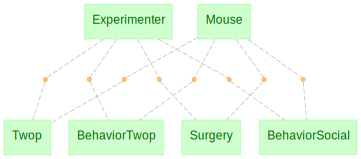

In [8]:
dj.Di(schema)

# Define ARD Import

In [9]:
def ard_import(file, investigator):
    """
    Take csv from eSirius, process data, and submit to DataJoint.
    file: directory of csv for new import
    investigator: string of experimenter name, "Last, First"
    """
    
    # Define list of ARD information found in eSirius csv
    # Species name, vendor name, order number, strain, sex, # animal per cage, # cages, arrival date
    ard_list = ['sp_nm', 'vend_nm', 'order_no', 'strain', 'sex', 'per_cage', 'cages', 'd_expect']
    
    # Read in the csv from ARD with pandas
    # Use file from argument, separator=',', use first row as header
    ard_file = pd.read_csv(file, sep=',', header=0)
    
    # Select only animals needed for investigator's project
    # use pandas.query() to select orders only for investigator of interest w/ @ method in pandas
    df_orders = ard_file.query("requestor == @investigator")
    
    # Parse dataframe for only relevant information using ard_list
    df_orders = df_orders[ard_list]
    
    # Set index name order_id
    df_orders.index.name = "order_id"
    
    # Parse time from csv into SQL compatible time
    # Select date expected column and map a lambda function to the columns values
    # Use map instead of apply because .map() is meant for series data
    df_orders['d_expect'] = df_orders['d_expect'].map(lambda x: datetime.strptime(x, '%x'))
    
    return(df_orders)
    
    

# Define Spawn Cages

In [10]:
def spawn_cages(r, num_animals, num_cages, database):
    """
    Take row, r, from dataframe generated from iterrows() and generate a cage of animals.
    Do this iteratively for the number of cages in each order.
    Each cage generated is inserted into the Database.
    Args:
    r: row from dataframe
    num_animals: dataframe.per_cage
    num_cages: dataframe.cages
    database: DataJoint database schema for insert statement
    """
    
    # For each cage received
    for cage in range(0, num_cages):
        
        # Get current state of database
        mouse_df = pd.DataFrame(Mouse.fetch()).set_index('id')

        # Select cage_id series from dataframe generated by DataJoint fetch
        cages = mouse_df.cage_id

        # Get last cage id
        max_cage_id = cages.max()
        
        # If no cage records exist, start one
        if math.isnan(max_cage_id) == True:
            new_cage_id = 1
        
        # If cage records exist, use last id and add 1
        else:
            new_cage_id = max_cage_id + 1

        # Define dictionary of values for later database submission, ard_dict:
        # Notice that animal_id is not collected. 
        # The Database will auto-increment the animal ids upon insertion.
        # Each animal has a unique ID in the database.
        ard_dict = {
        'sex':r.sex, 'species':r.sp_nm, 'strain':r.strain, 'vendor':r.vend_nm, 
        'arrived_on':r.d_expect, 'order_no':r.order_no, 'active':1, 'created':day,
        'cage_id': new_cage_id
        }

        # For each animal in a cage, create a dictionary and store it using list comprehension.
        # List of dictionaries is compatible with DataJoint insert statements.
        new_cage = [ard_dict for i in range(0, num_animals)]

        # Insert new cage with DataJoint insert statement.
        print("Order Number:", r.order_no, "Cage Number:", cage+1)
        Mouse.insert(new_cage)
        print("Inserted")
        
        # Reset new_cage
        new_cage = []
    
    return _
    
    

# Define Spawn Orders

In [16]:
def spawn_orders(dataframe):
    """
    Take in order dataframe generated from ard_import and use iterrows() to process each order.
    """
    # Use dataframe.iterrows() to take each order and spawn cages
    for index, row in dataframe.iterrows():
        spawn_cages(row, row.per_cage, row.cages, Mouse)
    
    return _

In [17]:
spawn_orders(ard_import(file, investigator))

Order Number: A0011304 Cage Number: 1
Inserted
Order Number: A0011304 Cage Number: 2
Inserted
Order Number: A0011304 Cage Number: 3
Inserted
Order Number: A0011304 Cage Number: 1
Inserted
Order Number: A0011304 Cage Number: 2
Inserted
Order Number: A0011304 Cage Number: 3
Inserted
Order Number: A0011237 Cage Number: 1
Inserted
Order Number: A0011237 Cage Number: 2
Inserted
Order Number: A0011237 Cage Number: 3
Inserted
Order Number: A0011237 Cage Number: 1
Inserted
Order Number: A0011237 Cage Number: 2
Inserted
Order Number: A0011237 Cage Number: 3
Inserted


,sex,species,strain,vendor,age,arrived_on,order_no,ard_id,cage_id,exp_code,active,created,updated
id,,,,,,,,,,,,,


In [18]:
df = pd.DataFrame(Mouse.fetch())
df.set_index('id')

,sex,species,strain,vendor,age,arrived_on,order_no,ard_id,cage_id,exp_code,active,created,updated
id,,,,,,,,,,,,,
1,M,Mice,C57BL/6,Jackson,56,2021-02-25,A0011304,None,1,None,1,2021-03-04,2021-03-04 18:56:47
2,M,Mice,C57BL/6,Jackson,56,2021-02-25,A0011304,None,1,None,1,2021-03-04,2021-03-04 18:56:47
3,M,Mice,C57BL/6,Jackson,56,2021-02-25,A0011304,None,1,None,1,2021-03-04,2021-03-04 18:56:47
4,M,Mice,C57BL/6,Jackson,56,2021-02-25,A0011304,None,1,None,1,2021-03-04,2021-03-04 18:56:47
5,M,Mice,C57BL/6,Jackson,56,2021-02-25,A0011304,None,2,None,1,2021-03-04,2021-03-04 18:56:47
6,M,Mice,C57BL/6,Jackson,56,2021-02-25,A0011304,None,2,None,1,2021-03-04,2021-03-04 18:56:47
7,M,Mice,C57BL/6,Jackson,56,2021-02-25,A0011304,None,2,None,1,2021-03-04,2021-03-04 18:56:47
8,M,Mice,C57BL/6,Jackson,56,2021-02-25,A0011304,None,2,None,1,2021-03-04,2021-03-04 18:56:47
9,M,Mice,C57BL/6,Jackson,56,2021-02-25,A0011304,None,3,None,1,2021-03-04,2021-03-04 18:56:47
